# COMP338 – Computer Vision – Assignment 1

## Task 1. (50 marks) 2D Convolution for Image Filtering

OpenCV provides a function cv.filter2D() to convolve a kernel with an image (See Lab 03 -
Image Manipulation and Lecture 5.). Given a kernel (or a filter) with any size, do the
following:

### 1. (25 marks) Reimplement the 2D convolution without using the built-in cv.filter2D() function.

In [1]:
import cv2

import matplotlib.pyplot as plt
import numpy as np

In [2]:
def my_filter2D_single_channel(image: np.ndarray, kernel: np.ndarray):
    kernel_height, kernel_width = kernel.shape

    if kernel_height != kernel_width or kernel_height % 2 == 0:
        raise ValueError("Kernel must be square with odd dimensions")

    image_height, image_width = image.shape
    image_padded = np.pad(image, ((1, 1), (1, 1)), 'constant', constant_values=0)
    image_filtered = np.zeros_like(image)

    for y in range(image_height):
        for x in range(image_width):
            sub_region = image_padded[y: y+kernel_height, x: x+kernel_width]
            image_filtered[y, x] = np.sum(sub_region * kernel)

    return image_filtered[1: -1, 1: -1]


def my_filter2D(image: np.ndarray, kernel: np.ndarray):
    channels = cv2.split(image)
    filtered_channels = [my_filter2D_single_channel(channel, kernel) for channel in channels]
    return cv2.merge(filtered_channels)

### 2. (10 marks) Test and visualize your implementation results.

In [3]:
image = cv2.imread(r'./pic/lena.png', cv2.IMREAD_UNCHANGED)
kernel = np.array((
        [0.0625, 0.125, 0.0625],
        [0.125, 0.25, 0.125],
        [0.0625, 0.125, 0.0625]), dtype="float32")

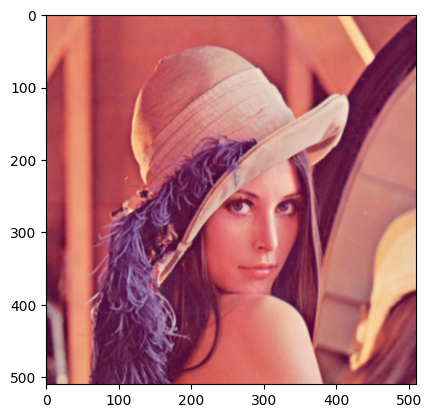

In [4]:
my_filtered_image = my_filter2D(image=image, kernel=kernel)
plt.imshow(my_filtered_image[:, :, [2, 1, 0]])

### 3. (15 marks) Discuss the difference between your implementation, your results compared with the OpenCV implementation.

In [5]:
def filter_result_comparison(image, my_filtered_image, cv2_filtered_image):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(image[:, :, [2, 1, 0]])
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(my_filtered_image[:, :, [2, 1, 0]])
    axes[1].set_title('Filtered by self function')
    axes[1].axis('off')

    axes[2].imshow(cv2_filtered_image[:, :, [2, 1, 0]])
    axes[2].set_title('Filtered by cv2 function')
    axes[2].axis('off')

    plt.show()

#### 3.1  A normal blurred kernel

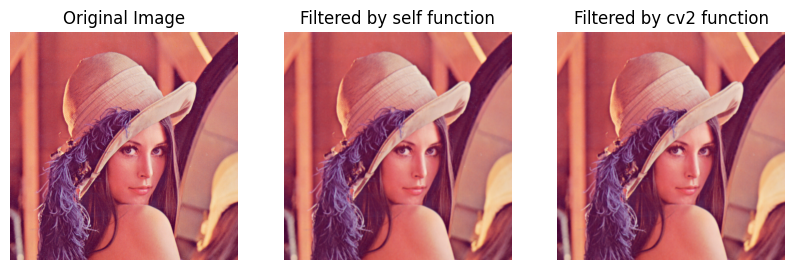

In [6]:
my_filtered_image = my_filter2D(image, kernel)
cv2_filtered_image = cv2.filter2D(image, -1, kernel)

filter_result_comparison(image, my_filtered_image, cv2_filtered_image)

#### 3.2  An emboss kernel

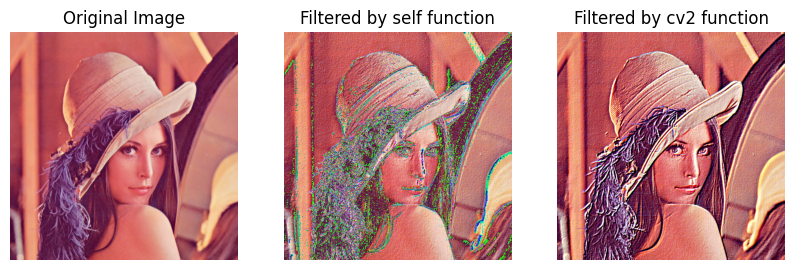

In [7]:
emboss_kernel = np.array((
        [-2, -1, 0],
        [-1, 1, 1],
        [0, 1, 2]), dtype="float32")
my_filtered_image_emboss = my_filter2D(image, emboss_kernel)
cv2_filtered_image_emboss = cv2.filter2D(image, -1, emboss_kernel)

filter_result_comparison(image, my_filtered_image_emboss, cv2_filtered_image_emboss)

#### 3.3 An outline kernel

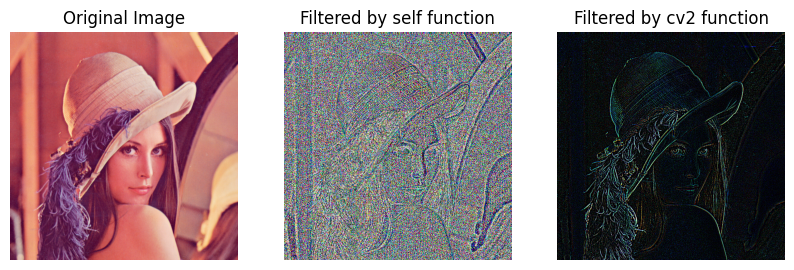

In [8]:
outline_kernel = np.array((
        [-1, -1, -1],
        [-1, 8, -1],
        [-1, -1, -1]), dtype="float32")
my_filtered_image_outline = my_filter2D(image, outline_kernel)
cv2_filtered_image_outline = cv2.filter2D(image, -1, outline_kernel)

filter_result_comparison(image, my_filtered_image_outline, cv2_filtered_image_outline)

Obviously, some kernels when applied to an image, have the same effect using their own function as the cv2 official one, but in some cases there are differences. Possible reasons include:
1. Boundary Handling: The cv2.filter2D() function controls how image boundaries are handled through the borderType parameter, which allows for options like BORDER_CONSTANT (usually zero padding), BORDER_REPLICATE (edge replication), BORDER_REFLECT (border reflection), etc. If the custom implementation does not precisely match the boundary handling of cv2.filter2D(), the results might differ. But the custom implementation might not be correctly accounting for boundary pixels, leading to neglected or incorrectly calculated contributions from these regions.
2. Data Type and Overflow: Image processing operations can lead to overflow if the pixel values after filtering exceed the range of the original data type, like 0-255 for uint8. If overflow is not properly managed with clipping or type conversion, different results will occur. cv2.filter2D() handles data overflow by default, while a custom implementation may require explicit overflow management.
3. Floating-point Precision: maybe kernel includes floating-point numbers, rounding errors during computation could also cause result discrepancies.
4. ...

## Task 2. (50 marks) Feature Extraction

### 1. (20 marks) Read the SURF and ORB papers and tutorials, summarize your understanding. Compare the differences between SIFT vs. SURF vs. ORB.

1.**SIFT**(**Scale-Invariant Feature Transform**) is developed by David Lowe (1999, 2004), the key attributes of that feature is scale and rotation invariance.

The process is: involves detecting extremities in scale-space as key points and generating descriptors from local image gradient directions.

SIFT is computationally expensive due to its detailed scale-space and gradient computations, which may not be suitable for real-time applications.

2.**SURF**(**Speeded Up Robust Features**) is developed by Bay et al. (2006), the key attributes of that feature is designed to improve the speed and efficiency of SIFT.

The process is: uses integral images for fast computation of Haar wavelet responses and finds key points in scale and image space. It employs a fast feature descriptor, which is a simplified version of the SIFT descriptor.

SURF is generally faster than SIFT but still time-consuming, although it has faster feature detection, it can still be slow at high scales.

3.**ORB**(**Oriented FAST and Rotated BRIEF**) is developed by Rublee et al. (2011), the key attributes is combines the benefits of the FAST keypoint detector and the BRIEF descriptor with added rotation invariance.

The process is: ORB first uses FAST to find key points, then applies the Harris corner measure to select the top N points, using a pyramid to produce scale invariance. Descriptors are computed, but to maintain rotation invariance, the intensity-weighted centroid of the patch around the keypoint is used, with orientation assigned relative to this centroid's direction.

ORB is typically faster than both SIFT and SURF, and is more efficient in terms of storage and comparison of descriptors due to its use of binary strings.

SIFT offers the strongest feature descriptors suited for applications that require precise feature matching but comes at the highest computational cost.

SURF attempts to balance speed with the robustness of features, suitable for applications that don't demand extreme real-time performance.

ORB is the fastest among the three, particularly suited for real-time applications and large-scale image processing, though it may lag behind SIFT in terms of the richness and precision of feature description.

Finally, it could be summrized as a table as following:

| Algorithm Name  |  Calculating Speed   | Rotation Robustness | Fuzzy Robustness |  Scaling Robustness   |
|:---------------:|:--------------------:|:-------------------:|:----------------:|:---------------------:|
|      SIFT       |       Slowest        |       Lowest        |      Lowest      |        Middle         |
|      SURF       |        Middle        |       Highest       |     Highest      |        Highest        |
|       ORB       |       Fastest        |       Middle        |      Middle      | No Scaling Robustness |

### 2. (10 marks) Given two images (victoria.jpg and victoria2.jpg – both available on Canvas), call OpenCV functions to extract the ORB keypoints. You can use the built-in functions from OpenCV. Visualize the detected keypoints.

In [2]:
def draw_small_keypoints(image, keypoints):
    for kp in keypoints:
        # Draw a small circle at each keypoint location
        image = cv2.circle(image, (int(kp.pt[0]), int(kp.pt[1])), 2, (0, 255, 0), -1)
    return image

In [13]:
victoria = cv2.imread(r'./pic/victoria.jpg', cv2.IMREAD_UNCHANGED)
victoria2 = cv2.imread(r'./pic/victoria2.jpg', cv2.IMREAD_UNCHANGED)

# Transform the format from BGR to RGB
victoria_rgb = cv2.cvtColor(victoria, cv2.COLOR_BGR2RGB)
victoria2_rgb = cv2.cvtColor(victoria2, cv2.COLOR_BGR2RGB)

victoria_gray = cv2.cvtColor(victoria, cv2.COLOR_BGR2GRAY)
victoria2_gray = cv2.cvtColor(victoria2, cv2.COLOR_BGR2GRAY)

# ORB Detector
orb = cv2.ORB_create()

# Detect keypoints with ORB
keypoints1, descriptors1 = orb.detectAndCompute(victoria_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(victoria2_gray, None)

# Draw keypoints on the images
# keypoints_victoria = cv2.drawKeypoints(victoria_rgb, keypoints1, None,
#                                        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# keypoints_victoria2 = cv2.drawKeypoints(victoria2_rgb, keypoints2, None,
#                                         flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
keypoints_victoria = draw_small_keypoints(victoria_rgb.copy(), keypoints1)
keypoints_victoria2 = draw_small_keypoints(victoria2_rgb.copy(), keypoints2)

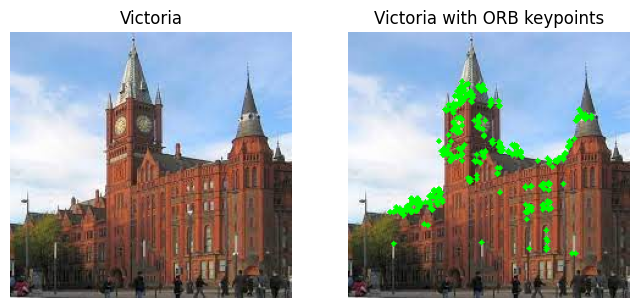

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

axes[0].imshow(victoria_rgb)
axes[0].set_title('Victoria')
axes[0].axis('off')

axes[1].imshow(keypoints_victoria)
axes[1].set_title('Victoria with ORB keypoints')
axes[1].axis('off')

plt.show()

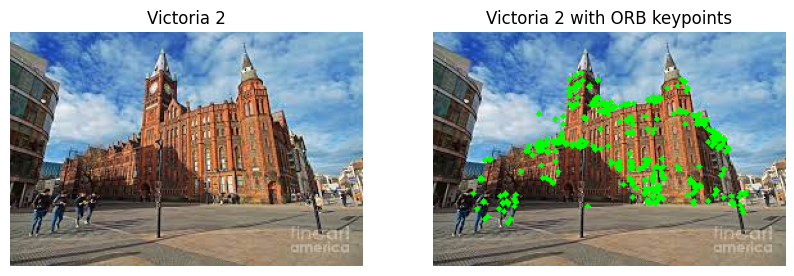

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

axes[0].imshow(victoria2_rgb)
axes[0].set_title('Victoria 2')
axes[0].axis('off')

axes[1].imshow(keypoints_victoria2)
axes[1].set_title('Victoria 2 with ORB keypoints')
axes[1].axis('off')

plt.show()

### 3. (20 marks) Given two images (victoria.jpg and victoria2.jpg), extract the descriptors using SIFT and ORB. Perform keypoint matching using Brute-Force Matcher. From the results, which method do you think perform the best? Justify your answer.

In [16]:
# ORB Detector
sift = cv2.SIFT_create()

# Detect keypoints with ORB
keypoints1_sift, descriptors1_sift = sift.detectAndCompute(victoria_gray, None)
keypoints2_sift, descriptors2_sift = sift.detectAndCompute(victoria2_gray, None)

# Draw keypoints on the images
# keypoints_victoria = cv2.drawKeypoints(victoria_rgb, keypoints1, None,
#                                        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# keypoints_victoria2 = cv2.drawKeypoints(victoria2_rgb, keypoints2, None,
#                                         flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
keypoints_victoria_sift = draw_small_keypoints(victoria_rgb.copy(), keypoints1)
keypoints_victoria2_sift = draw_small_keypoints(victoria2_rgb.copy(), keypoints2)

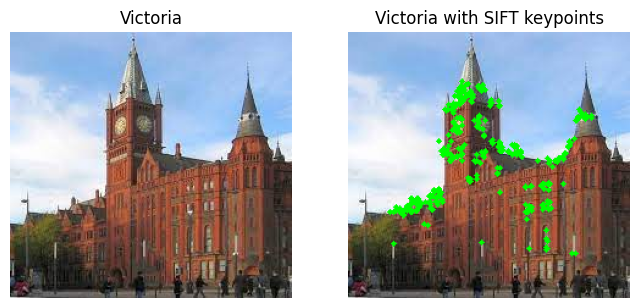

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

axes[0].imshow(victoria_rgb)
axes[0].set_title('Victoria')
axes[0].axis('off')

axes[1].imshow(keypoints_victoria_sift)
axes[1].set_title('Victoria with SIFT keypoints')
axes[1].axis('off')

plt.show()

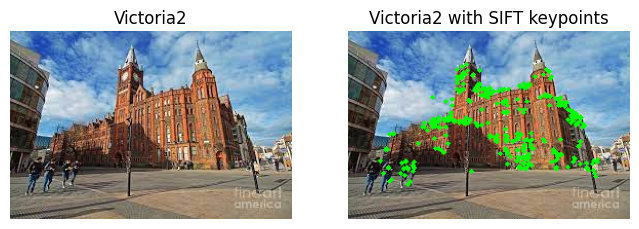

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

axes[0].imshow(victoria2_rgb)
axes[0].set_title('Victoria2')
axes[0].axis('off')

axes[1].imshow(keypoints_victoria2_sift)
axes[1].set_title('Victoria2 with SIFT keypoints')
axes[1].axis('off')

plt.show()

In [21]:
def match_features(img1, img2, method='SIFT'):
    if method == 'SIFT':
        # Initialize SIFT detector
        sift = cv2.SIFT_create()
        # Find the keypoints and descriptors with SIFT
        keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
        keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
        # BF matcher with default params and NORM_L2
        bf = cv2.BFMatcher(cv2.NORM_L2)

    elif method == 'ORB':
        # Initialize ORB detector
        orb = cv2.ORB_create()
        # Find the keypoints and descriptors with ORB
        keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
        keypoints2, descriptors2 = orb.detectAndCompute(img2, None)
        # BF matcher with NORM_HAMMING
        bf = cv2.BFMatcher(cv2.NORM_HAMMING)

    # Apply Lowe's ratio test
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Draw matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return img_matches

(-0.5, 505.5, 217.5, -0.5)

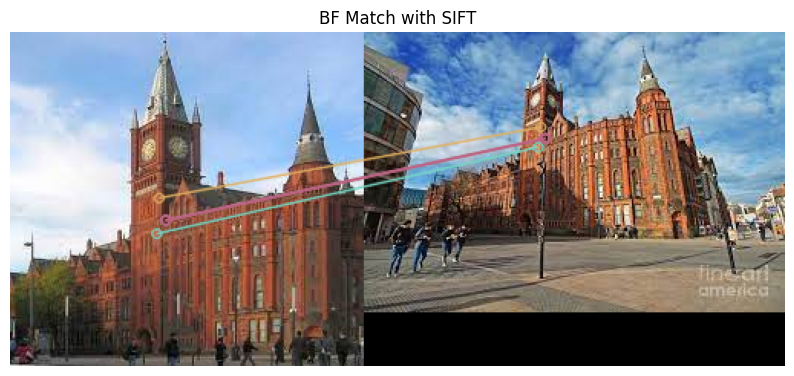

In [31]:
plt.figure(figsize=(10, 5))
img_matches_with_sift = match_features(victoria, victoria2, method='SIFT')
img_matches_with_sift = cv2.cvtColor(img_matches_with_sift, cv2.COLOR_BGR2RGB)

plt.imshow(img_matches_with_sift)
plt.title('BF Match with SIFT')
plt.axis('off')

(-0.5, 505.5, 217.5, -0.5)

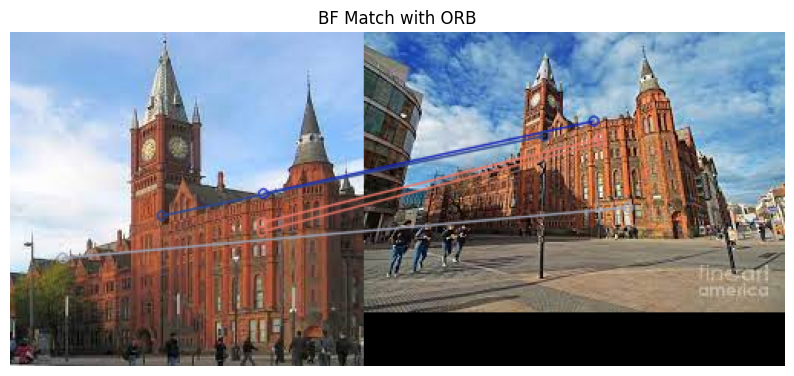

In [33]:
plt.figure(figsize=(10, 5))
img_matches_with_orb = match_features(victoria, victoria2, method='ORB')
img_matches_with_orb = cv2.cvtColor(img_matches_with_orb, cv2.COLOR_BGR2RGB)

plt.imshow(img_matches_with_orb)
plt.title('BF Match with ORB')
plt.axis('off')

Based on the visual output, both SIFT and ORB identified and matched multiple keypoints between the two images. In terms of pure visual matching quality, SIFT generally appears to perform better due to its more detailed descriptors. However, the computational performance of ORB is also high.

Personally, for the description of image matching results, the importance of accuracy is definitely greater than time efficiency. Users are more interested in the accuracy of the match than in time (unless they are spending so much time that they can no longer expect to get a result in a time frame).